In [309]:
# Compute Hanno's Method for N particles 

%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import math as m
import numpy as np
from numpy import linalg as LA  # for norm
import timeit

In [310]:
# Gravitational constant
G = 1

# Name of file to read. Contains ICs
fileName = "particleInfo.txt"

File = open(fileName,"r")
lines = File.readlines()

# number of planets in simulation
numPlanets = len(lines)-1

File.close()

nullVec = np.zeros(3)

# Initialize masses, r's and v's to 0's
M = np.zeros(numPlanets)
r = np.zeros((len(M),3))
v = np.zeros((len(M),3))

# timestep (arbitrary)
dt = 0.05

# number of timesteps (arbitrary)
numSteps = 200
dim = 3

In [311]:
# Fill M, r and v with data from file
def initial_Conditions(r,v,M,fileName):
    
    File = open(fileName,"r")
    lines = File.readlines()
    
    for i in np.arange(len(lines))[1:]:
        info = lines[i].split()
        M[i-1] = float(info[0])
        r[i-1] = np.array([float(info[1]),float(info[2]),float(info[3])])
        v[i-1] = np.array([float(info[4]),float(info[5]),float(info[6])])

    File.close()
    
    return r,v,M

r,v,M = initial_Conditions(r,v,M,fileName)

In [312]:
def A1(r,v,dt,dim):
    
    # update position of all particles
    for i in np.arange(len(r)):
        for j in np.arange(dim):
            r[i][j] += v[i][j]*dt
    
    return r

In [313]:
def A2(r,v,M,dt,dim):
    
    # Hold the sum of forces on particle 0
    acc = np.zeros(3)
    dirVec = np.zeros(3)
    
    # update velocities
    for i in np.arange(len(v))[1:]:
        for j in np.arange(dim):
            # the part of r that we need for norm
            # for particle 0 and particle i
            dirVec[j] = r[0][j] - r[i][j]  
        for j in np.arange(dim):
            v[i][j] += M[0]/(LA.norm(dirVec)**3)*dt*dirVec[j]
            # -1 accounts for direction along 0 to i instead of i to 0
            acc[j] -= M[i]/(LA.norm(dirVec)**3)*dirVec[j]
    for i in np.arange(dim):
        v[0][i] += acc[i]*dt
    
    return v

In [314]:
def B(r,v,M,dt,dim):
    
    dirVec = np.zeros(3)
    
    # Hold the sum of forces on each particle 
    acc = np.zeros((len(r),3))
    
    # compute sum of forces
    for i in np.arange(len(v))[1:]:
        for j in np.arange(len(v))[i+1:]:
            for k in np.arange(dim):
                dirVec[k] = r[i][k] - r[j][k]
            for k in np.arange(dim):
                acc[i][k] -= M[j]/(LA.norm(dirVec)**3)*dirVec[k]
                acc[j][k] += M[i]/(LA.norm(dirVec)**3)*dirVec[k]
                    
    # update velocities
    for i in np.arange(len(v))[1:]:
        for j in np.arange(dim):
            v[i][j] += acc[i][j]*dt
            
    return v

In [315]:
# Calculate energy of the system
def energy(r,v,M):
    
    # T = kinetic energy, U = potential energy
    T = 0.0
    U = 0.0
    dirVec = np.zeros(3)

    for i in np.arange(len(r)):
        T += 0.5*M[i]*LA.norm(v[i])**2
        for j in np.arange(len(r))[i+1:]:
            for k in np.arange(3):
                dirVec[k] = r[i][k] - r[j][k]
            U -= M[i]*M[j]/(LA.norm(dirVec))
    # Total energy
    E = T + U
    
    return E

In [316]:
# Generate a plot in 3D space of all planets
def runPlot(r,v,M,numSteps,n):
    
    # number of dimensions (2 or 3)
    dim = len(r[0])
    
    numPlanets = len(r)
    
    # Store the updated values 
    # Format: Rx = [x01,x11,...,xN1,x02,x12,...,xN2,...]
    # First digit is the particle, second is the time step
    Rx = np.zeros(numSteps*numPlanets)
    Ry = np.zeros(numSteps*numPlanets)
    Rz = np.zeros(numSteps*numPlanets)
    
    for i in np.arange(numSteps):
        for j in np.arange(numPlanets):
            
            # x,y and z components of each planet 
            # for each time step
            Rx[numPlanets*i+j] = r[j][0]
            Ry[numPlanets*i+j] = r[j][1]
            Rz[numPlanets*i+j] = r[j][2]
        
        # one full time step
        for k in np.arange(n):
            r = A1(r,v,dt/(n*4.),dim)
            v = A2(r,v,M,dt/(n*2.),dim)
            r = A1(r,v,dt/(n*4.),dim)
        
        v = B(r,v,M,dt,dim)
        
        for k in np.arange(n):
            r = A1(r,v,dt/(n*4.),dim)
            v = A2(r,v,M,dt/(n*2.),dim)
            r = A1(r,v,dt/(n*4.),dim)
        
    fig = plt.figure(1)
    ax = fig.add_subplot(111,projection='3d')
    for i in np.arange(numPlanets):
        ax.plot(Rx[i::numPlanets],Ry[i::numPlanets],Rz[i::numPlanets])
    plt.title("Real Space N Body Problem")
    ax.set_xlabel('x')
    ax.set_ylabel('y')    
    ax.set_zlabel('z')    
    
    plt.show()

In [317]:
# Calculate the error for each time step as well as run time
# and plot it
def runError(r,v,M,n):
    
    # amount of time to pass regardless of 
    # how small dt is
    total_time = 1.
    
    # Loop over time steps
    timeStep_iter = np.logspace(-4,0,100)
    #timeStep_iter = np.linspace(0.0001,1,100)
    numSteps = np.array([total_time/i for i in timeStep_iter])
    # Largest relative error
    rel_err = np.zeros(len(timeStep_iter))
    # For run time
    start = np.zeros(len(timeStep_iter))
    stop = np.zeros(len(timeStep_iter))
    
    # To hold the run time for each time step
    runTime = np.zeros(len(timeStep_iter))
    
    # Initial energy
    E0 = energy(r,v,M)
    
    for i in np.arange(len(timeStep_iter)):
        
        # Holds relative error for each time step
        rel_err_iter = np.zeros(int(m.ceil(numSteps[i])))
        start[i] = timeit.default_timer()
        
        for j in np.arange(int(m.ceil(numSteps[i]))):
        
            # one full time step
            for k in np.arange(n):
                r = A1(r,v,timeStep_iter[i]/(n*4.),dim)
                v = A2(r,v,M,timeStep_iter[i]/(n*2.),dim)
                r = A1(r,v,timeStep_iter[i]/(n*4.),dim)
                
            v = B(r,v,M,timeStep_iter[i],dim)
            
            for k in np.arange(n):
                r = A1(r,v,timeStep_iter[i]/(n*4.),dim)
                v = A2(r,v,M,timeStep_iter[i]/(n*2.),dim)
                r = A1(r,v,timeStep_iter[i]/(n*4.),dim)
                
            rel_err_iter[j] = abs((E0-energy(r,v,M))/E0)
       
        stop[i] = timeit.default_timer()
        runTime[i] = stop[i] - start[i]
    
        rel_err[i] = max(rel_err_iter)
     
    plt.figure(2)   
    plt.loglog(timeStep_iter,rel_err,label='HR')
    plt.legend(loc='best')
    plt.xlabel('Time Step')
    plt.ylabel('Relative Error')    
    
    plt.figure(3)    
    plt.loglog(runTime,rel_err,label='HR')
    plt.legend(loc='best')
    plt.xlabel('Run Time')
    plt.ylabel('Relative Error')
    
    plt.show()

<IPython.core.display.Javascript object>


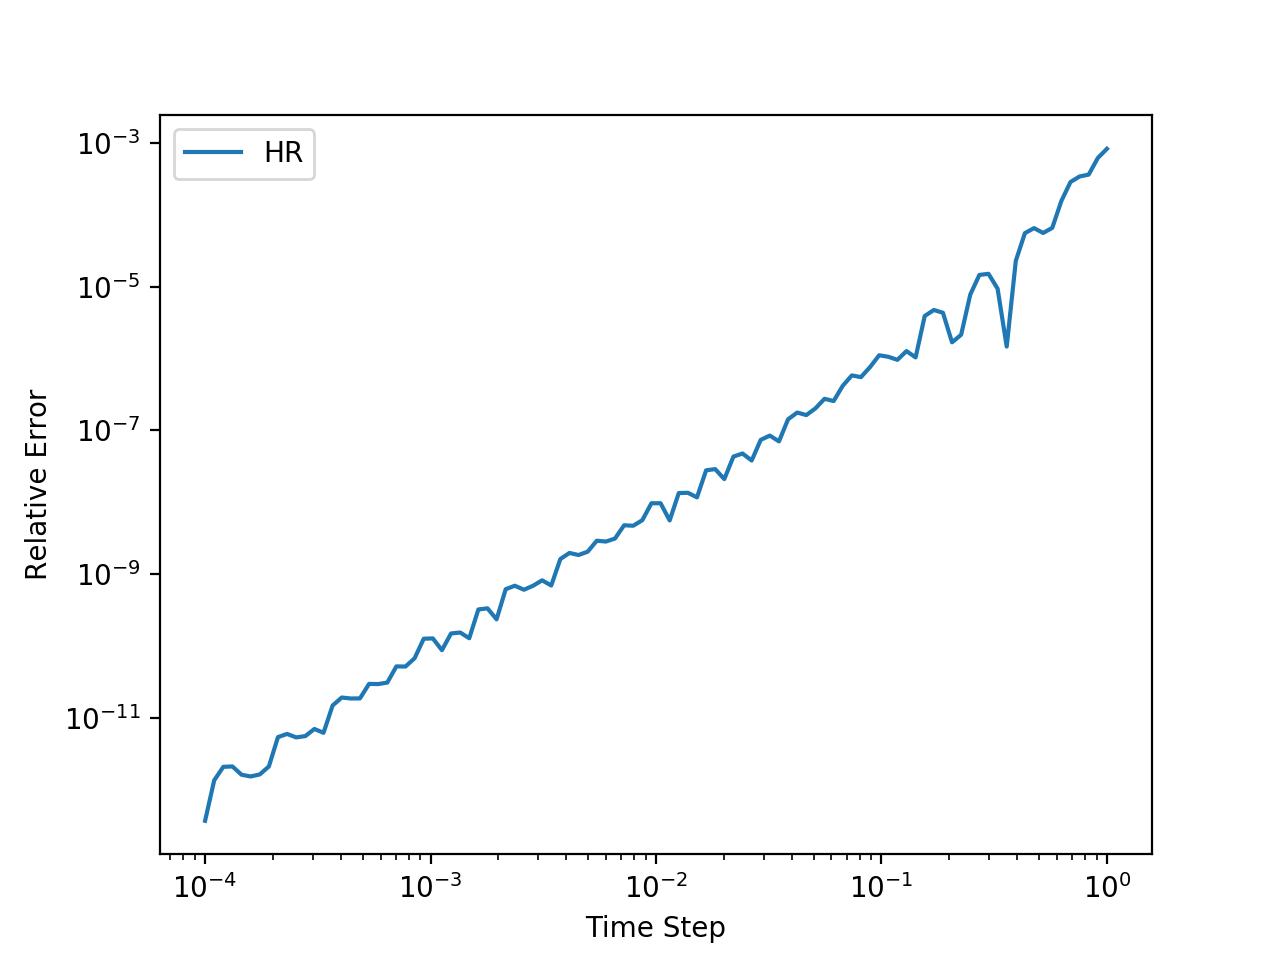

<IPython.core.display.Javascript object>


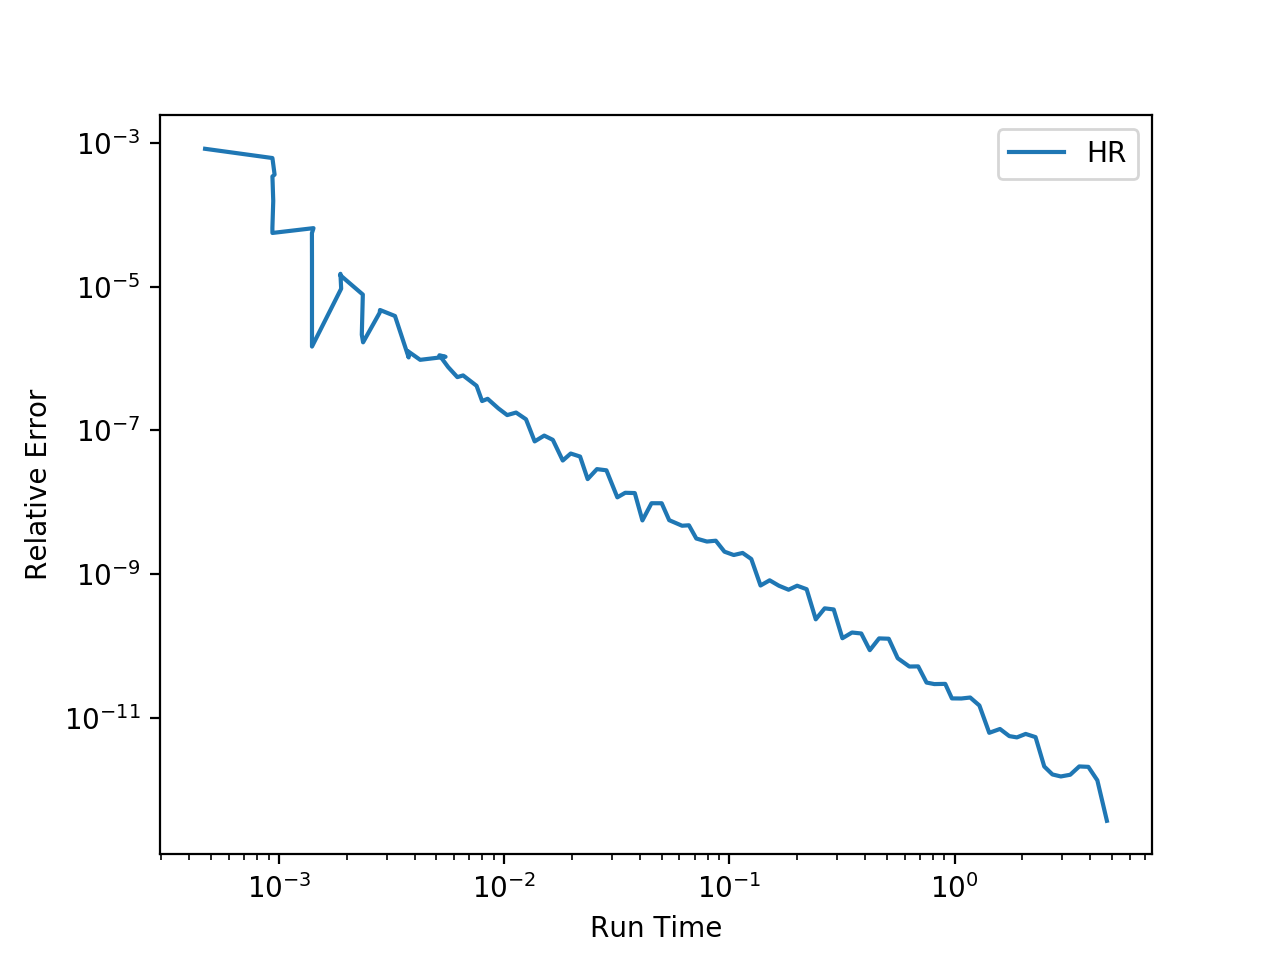

In [318]:
#runPlot(r,v,M,numSteps,1)
runError(r,v,M,1)

In [285]:
acc = np.zeros((len(r),3))
print(acc)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
